In [27]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [2]:
train_dataset = datasets.FashionMNIST(root='./data', transform=ToTensor(), download=True, train=True)

test_dataset = datasets.FashionMNIST(root='./data', transform=ToTensor(), download=True, train=False)


100%|██████████| 26421880/26421880 [00:02<00:00, 9543989.34it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 149286.98it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2806213.51it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8307917.27it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [3]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [4]:
class_names = train_dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [5]:
calibration_size = int(0.02*len(train_dataset))
remaining_size = len(train_dataset) - calibration_size

calibration_set, train_set = random_split(train_dataset, [calibration_size, remaining_size])

In [6]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
calibration_loader = DataLoader(calibration_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
class model1(nn.Module):
  def __init__(self, in_shape, hidden_units, out_shape):
    super().__init__()

    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=in_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(490, out_shape)
    )

  def forward(self, x):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

model = model1(1, 10, 10).to(device)


In [19]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [20]:
from tqdm.auto import tqdm
def train_function(model, device, train_dataloader, loss_function, optimizer, accuracy_function):
  model.train()
  model = model.to(device)
  training_loss = 0
  trng_acc = 0
  for X_train, y_train in tqdm(train_dataloader):
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_train_logits = model(X_train)
    loss = loss_function(y_train_logits, y_train)
    training_loss += loss
    trng_acc += accuracy_function(y_train, torch.argmax(y_train_logits, dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  # find average loss per batch
  return (training_loss/len(train_dataloader), trng_acc/len(train_dataloader))

In [21]:
for epoch in range(10):
  loss, acc = train_function(model, device, train_loader, loss_fn, optimizer, accuracy_function)
  print(f'epoch: {epoch+1} | loss: {loss:.4f} | accuracy: {acc:.4f}%')

  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 1 | loss: 1.3005 | accuracy: 53.5807%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 2 | loss: 0.5434 | accuracy: 79.9731%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 3 | loss: 0.4685 | accuracy: 82.9111%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 4 | loss: 0.4318 | accuracy: 84.2781%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 5 | loss: 0.4023 | accuracy: 85.3866%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 6 | loss: 0.3809 | accuracy: 86.4289%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 7 | loss: 0.3612 | accuracy: 87.1532%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 8 | loss: 0.3460 | accuracy: 87.5833%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 9 | loss: 0.3340 | accuracy: 88.0016%


  0%|          | 0/1838 [00:00<?, ?it/s]

epoch: 10 | loss: 0.3230 | accuracy: 88.3739%


In [30]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for img, label in calibration_loader:
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    softmax_scores = torch.softmax(outputs, dim=1)
    true_softmax = softmax_scores.gather(1, label.unsqueeze(1)).squeeze()
    conformal_scores.append(1-true_softmax)

conformal_scores = torch.cat(conformal_scores)
conformal_scores = conformal_scores.cpu().numpy()

In [33]:
n = len(calibration_set)
alpha = 0.05
q_level = np.ceil((n+1)*(1-alpha)) / n
qhat = np.quantile(conformal_scores, q_level, method='higher')
qhat

0.81881666

In [45]:
import random
#select 10 indices from the test_data
test_indices = list(range(len(test_dataset)))
selected_indices = random.sample(test_indices, 10)
new_samples = torch.utils.data.Subset(test_dataset, selected_indices)

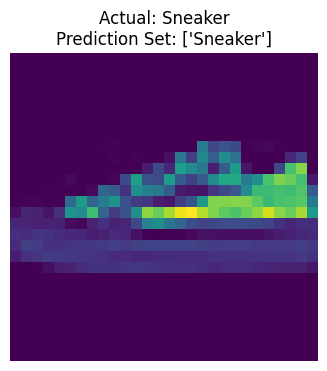

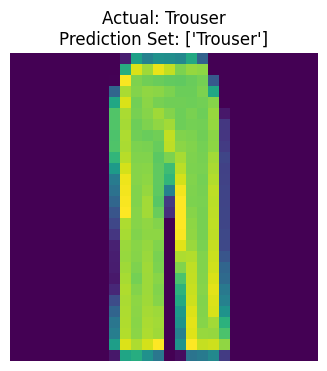

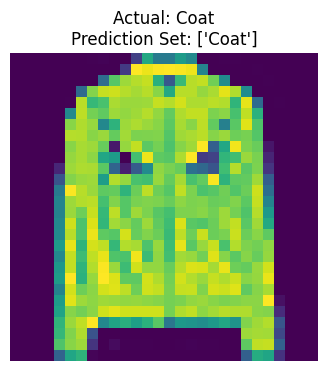

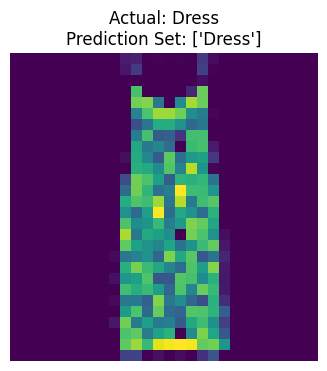

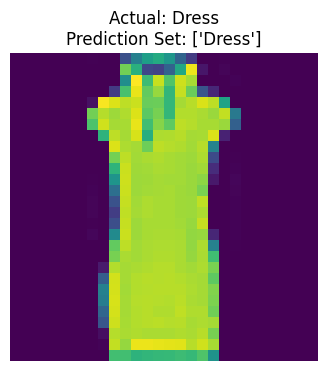

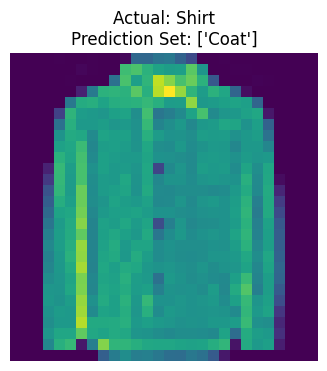

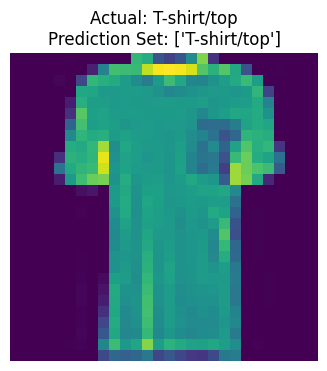

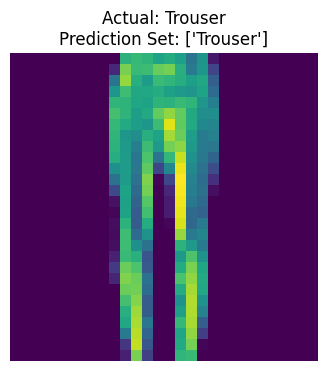

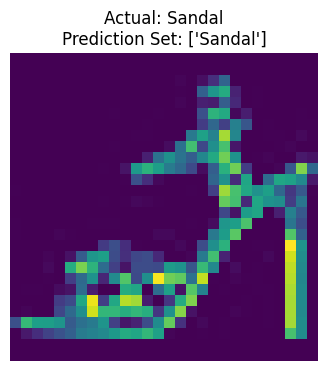

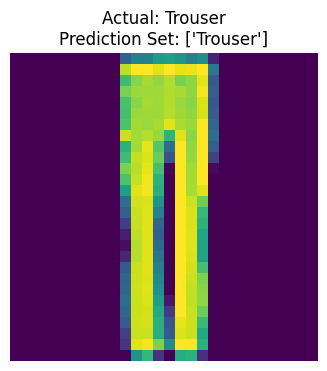

In [46]:
import matplotlib.pyplot as plt

prediction_sets = []
class_names = train_dataset.classes
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in enumerate(new_samples):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]

    plt.figure(figsize=(8, 4))
    plt.imshow(img.cpu().squeeze())
    plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
    plt.axis('off')
    plt.show()

In [38]:
import numpy as np

n_classes = len(class_names)
confusion_matrix = np.zeros((n_classes, 2))

In [40]:
from torch.utils.data import DataLoader

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
model.eval()
with torch.inference_mode():
  for img, label in tqdm(test_loader):
      img = img.to(device)
      outputs = model(img)
      softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
      prediction_set = np.where(softmax_probs >= (1-qhat))[0]


      if label.item() in prediction_set:
          confusion_matrix[label, 0] += 1
      for idx in prediction_set:
          if idx != label.item():
              confusion_matrix[idx, 1] += 1


  0%|          | 0/10000 [00:00<?, ?it/s]

In [41]:
print(confusion_matrix)

[[903. 282.]
 [983.  28.]
 [932. 520.]
 [963. 308.]
 [932. 521.]
 [980.  64.]
 [849. 858.]
 [982. 129.]
 [973.  50.]
 [984. 127.]]


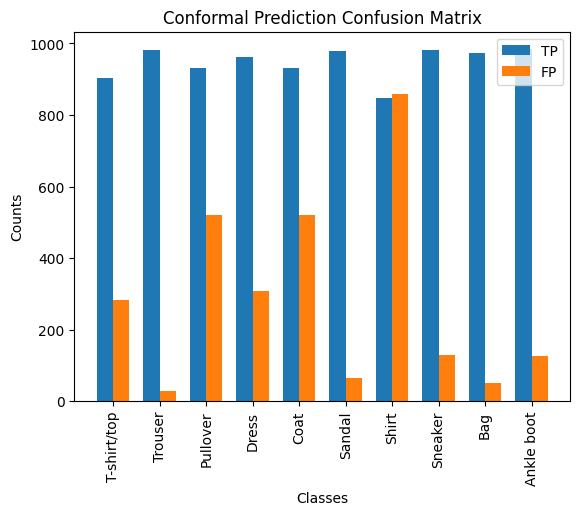

In [42]:
import matplotlib.pyplot as plt

bar_width = 0.35
index = np.arange(n_classes)
fig, ax = plt.subplots()
bar1 = ax.bar(index, confusion_matrix[:, 0], bar_width, label='TP')
bar2 = ax.bar(index + bar_width, confusion_matrix[:, 1], bar_width, label='FP')

ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Conformal Prediction Confusion Matrix')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(class_names, rotation=90)
ax.legend()

plt.show()